### Relationship between the US Unemployment Rate and Median House Sale Price in the US. 
#### Unemployment is an important indicators used to explain US economy performance, and it is proved to be highly correlated to recession. On the other hand, Housing market is always involved either directly or indirectly in US recession, especially in 2008.
#### This analysis wants to explore whether housing price can be used an a predictor to US recession (using umeployment rate to represent the recession cycle). They are very likely to have a negative correlation as housing market usually goes down when unemployment goes up. It's also very likely there would be lagging effects between the two, as housing market usually starts to go down before umemployment starts to go up. If there are measurable lags, how many months would that be? 

Data source from FRED:
1. Median Sales Price for New Houses Sold in the United States (MSPNHSUS)
2. Unemployment Rate (UNRATE)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [5]:
df_unrate = pd.read_csv (r'D:\JupyterNotebook\HG_Vora\UNRATE.csv')
df_unrate = df_unrate.set_index(pd.to_datetime(df_unrate['DATE']))
df_unrate = df_unrate.drop(['DATE'], axis = 1)
df_unrate.head()

,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [4]:
df_house = pd.read_csv (r'D:\JupyterNotebook\HG_Vora\MSPNHSUS.csv')
df_house = df_house.set_index(pd.to_datetime(df_house['DATE']))
df_house = df_house.drop(['DATE'], axis = 1)
df_house.head()

,MSPNHSUS
DATE,
1963-01-01,17200.0
1963-02-01,17700.0
1963-03-01,18200.0
1963-04-01,18200.0
1963-05-01,17500.0


In [7]:
master =  pd.concat([df_unrate, df_house], axis=1)
master = master.dropna()
master.head()

,UNRATE,MSPNHSUS
DATE,,
1963-01-01,5.7,17200.0
1963-02-01,5.9,17700.0
1963-03-01,5.7,18200.0
1963-04-01,5.7,18200.0
1963-05-01,5.9,17500.0


## Exploratory Analysis/Visualize the Data

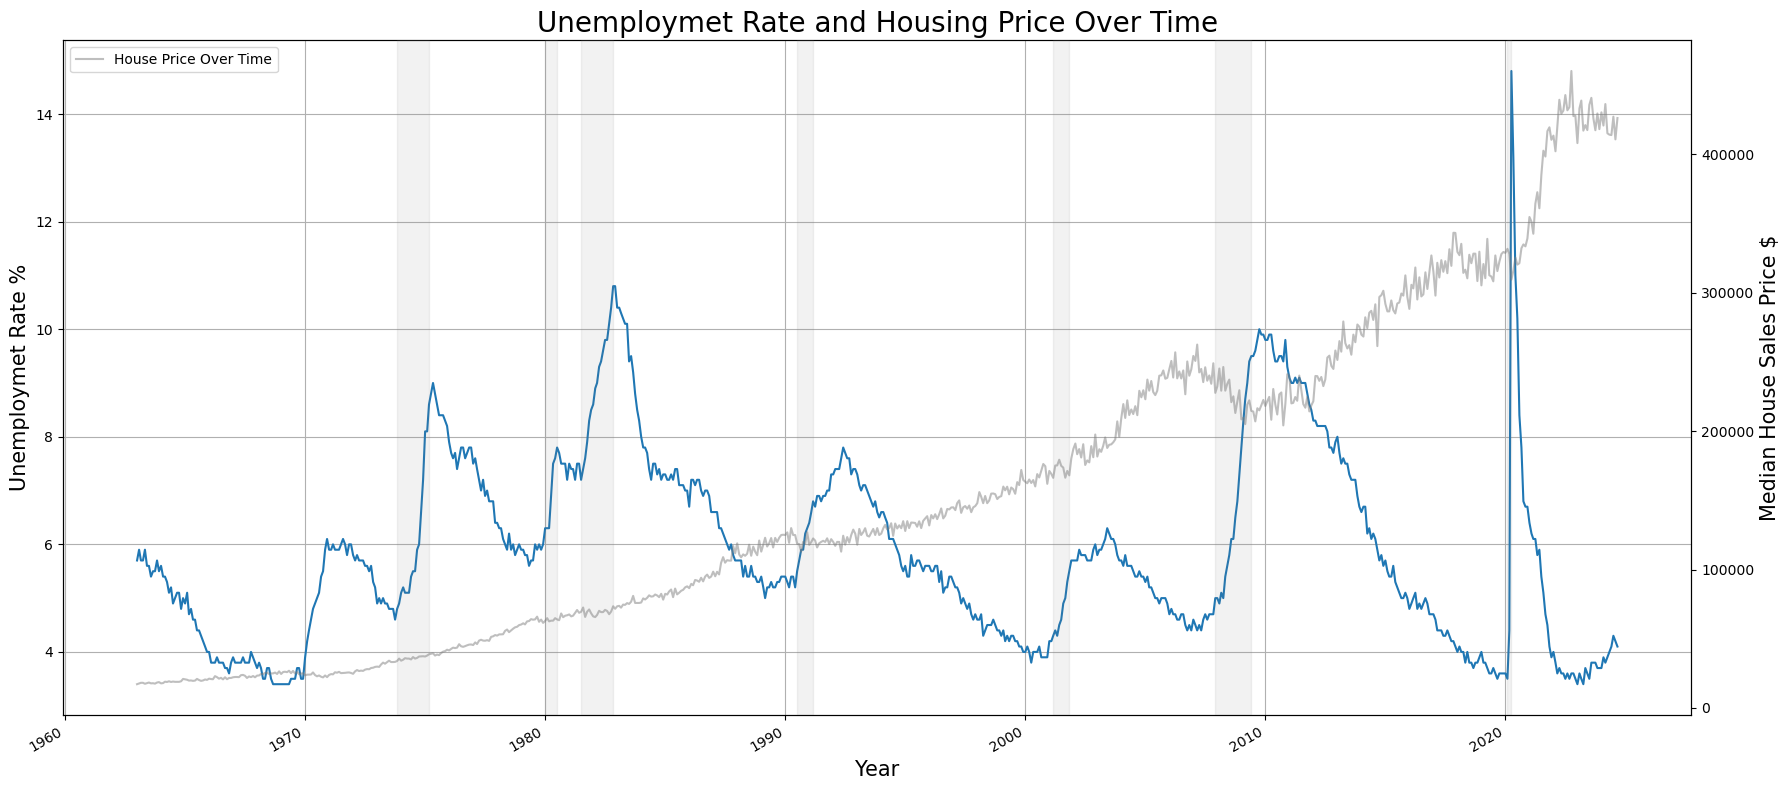

In [13]:
from datetime import datetime, date

# Created a graph to visualize the raw data
fig, ax1 = plt.subplots(figsize = (18,8))
ax1.plot(master.index, 'UNRATE', data=master, color = 'tab:blue',label = 'Unemployment')
ax1.set_xlabel('Year',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_ylabel('Unemploymet Rate %',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_title('Unemploymet Rate and Housing Price Over Time', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax1.grid(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(master.index, 'MSPNHSUS', data=master, color = 'tab:gray', alpha=0.5,label = 'House Price Over Time')
ax2.tick_params(axis = 'y')
ax2.set_ylabel('Median House Sales Price $', size = 15)
plt.legend(loc='upper left')

#Year period for recessions defined by Wikipedia list of recessions
ax3 = ax1.twinx()
ax3.axvspan(datetime(1980, 1, 1),datetime(1980, 7, 1),alpha=0.1,color='gray')
ax3.axis('off')

ax4 = ax1.twinx()
ax4.axvspan(datetime(1981, 7, 1),datetime(1982, 11, 1),alpha=0.1,color='gray')
ax4.axis('off')

ax5 = ax1.twinx()
ax5.axvspan(datetime(1990, 7, 1),datetime(1991, 3, 1),alpha=0.1,color='gray')
ax5.axis('off')

ax6 = ax1.twinx()
ax6.axvspan(datetime(2001, 3, 1),datetime(2001, 11, 1),alpha=0.1,color='gray')
ax6.axis('off')

ax7 = ax1.twinx()
ax7.axvspan(datetime(2007, 12, 1),datetime(2009, 6, 1),alpha=0.1,color='gray')
ax7.axis('off')

ax8 = ax1.twinx()
ax8.axvspan(datetime(2020, 2, 1),datetime(2020, 4, 1),alpha=0.1,color='gray')
ax8.axis('off')

ax9 = ax1.twinx()
ax9.axvspan(datetime(1973, 11, 1),datetime(1975, 3, 1),alpha=0.1,color='gray')
ax9.axis('off')


# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Talking points:
# 1. Umeployment Rate is highly correlated with recession 
# 2. Umemployment go up during recession
# 3. Housing price starts to go down before recession

### 1. Stationarity Test (Remove Trends and Seasonality)

In [14]:
from statsmodels.tsa.stattools import adfuller
def testStationary(df, col, resultdf):
    dftest = adfuller(df[col], autolag = 'AIC')
    print('Column: ', col)
    print("P-Value : ", dftest[1])
    if dftest[0] < dftest[4]["5%"]:
        print('reject Ho - it is stationary')
        result = 'stationary'
    else:
        print('failed to reject Ho - it is non-stationary')
        result = 'non-stationary'
    
    # Create a new row as a dictionary
    new_row = [col, dftest[1], result]
    # Append the new row
    resultdf.loc[len(resultdf)] = new_row

In [15]:
#result dataframe for stationary test
stationary_df = pd.DataFrame(columns=['Column','P-Value', 'Result'])

In [16]:
#FRED says this time series is seasonaly adjusted. It is stationary but P-value is not very low
testStationary(master, 'UNRATE',stationary_df)

Column:  UNRATE
P-Value :  0.016579098664769233
reject Ho - it is stationary


In [17]:
#This doesn't look stationary at all, need to remove trends and not use the raw data in analysis
testStationary(master, 'MSPNHSUS',stationary_df)

Column:  MSPNHSUS
P-Value :  0.9973931585502119
failed to reject Ho - it is non-stationary


In [18]:
master['UNRATE_diff']=master['UNRATE'].diff(1)
master['house_diff']=master['MSPNHSUS'].diff(1)
master['house_return']= master['MSPNHSUS'].pct_change(1)
master = master.dropna()
master.tail()

,UNRATE,MSPNHSUS,UNRATE_diff,house_diff,house_return
DATE,,,,,
2024-05-01,4.0,414300.0,0.1,-1000.0,-0.002408
2024-06-01,4.1,414000.0,0.1,-300.0,-0.000724
2024-07-01,4.3,427300.0,0.2,13300.0,0.032126
2024-08-01,4.2,410900.0,-0.1,-16400.0,-0.038381
2024-09-01,4.1,426300.0,-0.1,15400.0,0.037479


In [19]:
testStationary(master, 'UNRATE_diff',stationary_df)

Column:  UNRATE_diff
P-Value :  1.084010633934973e-27
reject Ho - it is stationary


In [20]:
testStationary(master, 'house_diff',stationary_df)

Column:  house_diff
P-Value :  1.0845421411142084e-06
reject Ho - it is stationary


In [21]:
testStationary(master, 'house_return',stationary_df)

Column:  house_return
P-Value :  2.3239647603020555e-05
reject Ho - it is stationary


In [22]:
# To summary
stationary_df

,Column,P-Value,Result
0,UNRATE,1.657910e-02,stationary
1,MSPNHSUS,9.973932e-01,non-stationary
2,UNRATE_diff,1.084011e-27,stationary
3,house_diff,1.084542e-06,stationary
4,house_return,2.323965e-05,stationary


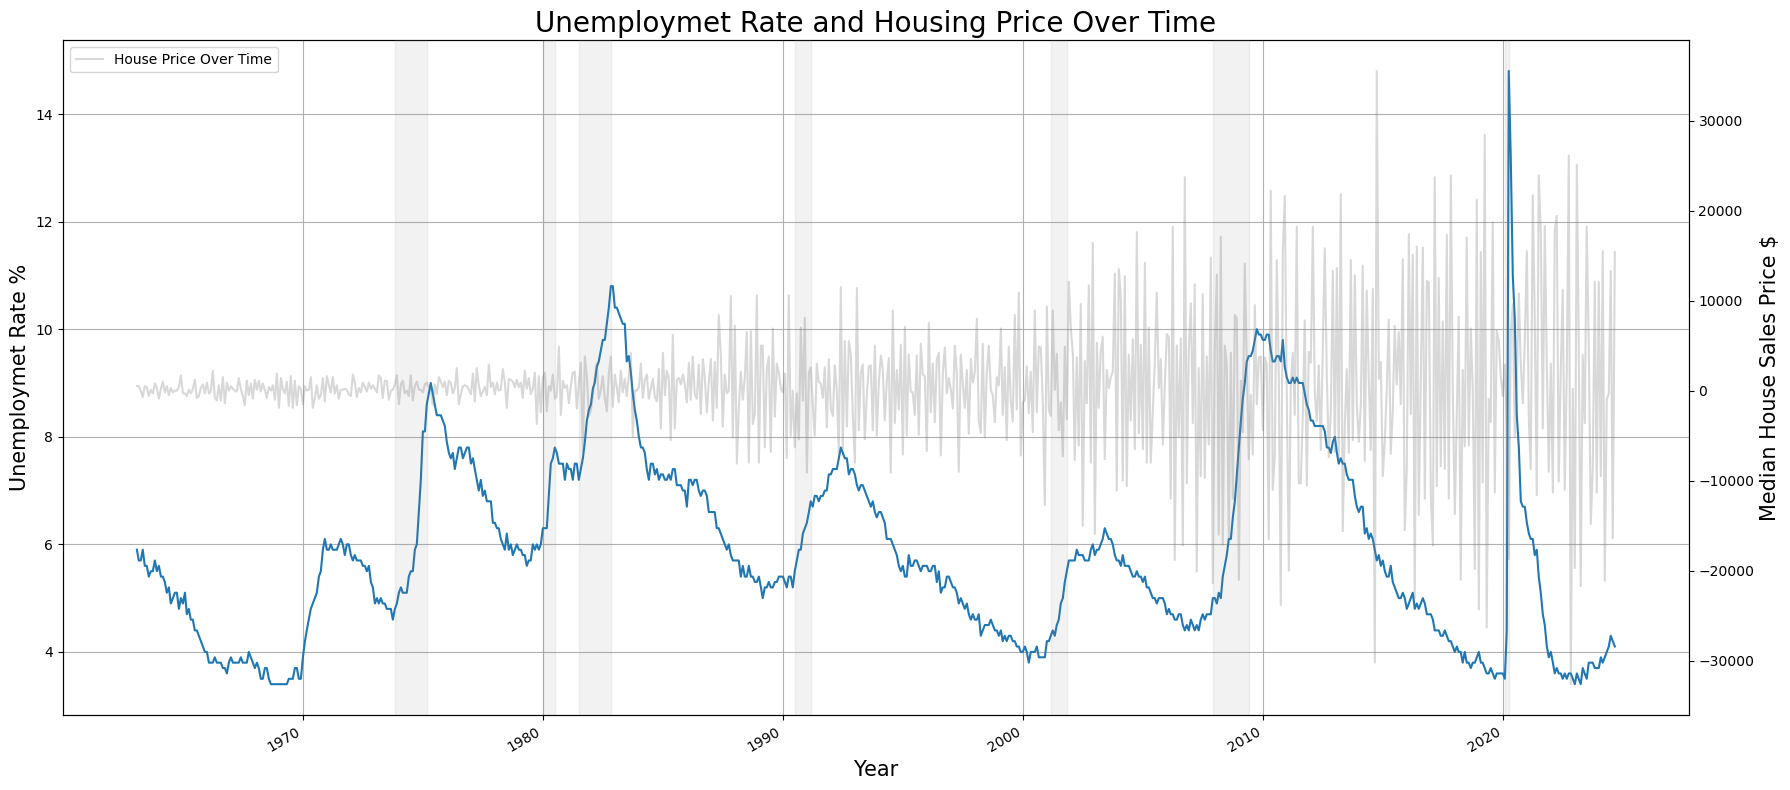

In [77]:
from datetime import datetime, date

# Created a graph to visualize the raw data
fig, ax1 = plt.subplots(figsize = (18,8))
ax1.plot(master.index, 'UNRATE', data=master, color = 'tab:blue',label = 'Unemployment')
ax1.set_xlabel('Year',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_ylabel('Unemploymet Rate %',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_title('Unemploymet Rate and Housing Price Over Time', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax1.grid(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(master.index, 'house_diff', data=master, color = 'tab:gray', alpha=0.3,label = 'House Price Over Time')
ax2.tick_params(axis = 'y')
ax2.set_ylabel('Median House Sales Price $', size = 15)
plt.legend(loc='upper left')

#Year period for recessions defined by Wikipedia list of recessions
ax3 = ax1.twinx()
ax3.axvspan(datetime(1980, 1, 1),datetime(1980, 7, 1),alpha=0.1,color='gray')
ax3.axis('off')

ax4 = ax1.twinx()
ax4.axvspan(datetime(1981, 7, 1),datetime(1982, 11, 1),alpha=0.1,color='gray')
ax4.axis('off')

ax5 = ax1.twinx()
ax5.axvspan(datetime(1990, 7, 1),datetime(1991, 3, 1),alpha=0.1,color='gray')
ax5.axis('off')

ax6 = ax1.twinx()
ax6.axvspan(datetime(2001, 3, 1),datetime(2001, 11, 1),alpha=0.1,color='gray')
ax6.axis('off')

ax7 = ax1.twinx()
ax7.axvspan(datetime(2007, 12, 1),datetime(2009, 6, 1),alpha=0.1,color='gray')
ax7.axis('off')

ax8 = ax1.twinx()
ax8.axvspan(datetime(2020, 2, 1),datetime(2020, 4, 1),alpha=0.1,color='gray')
ax8.axis('off')

ax9 = ax1.twinx()
ax9.axvspan(datetime(1973, 11, 1),datetime(1975, 3, 1),alpha=0.1,color='gray')
ax9.axis('off')


# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### 2. Correlation Between series we have so far....

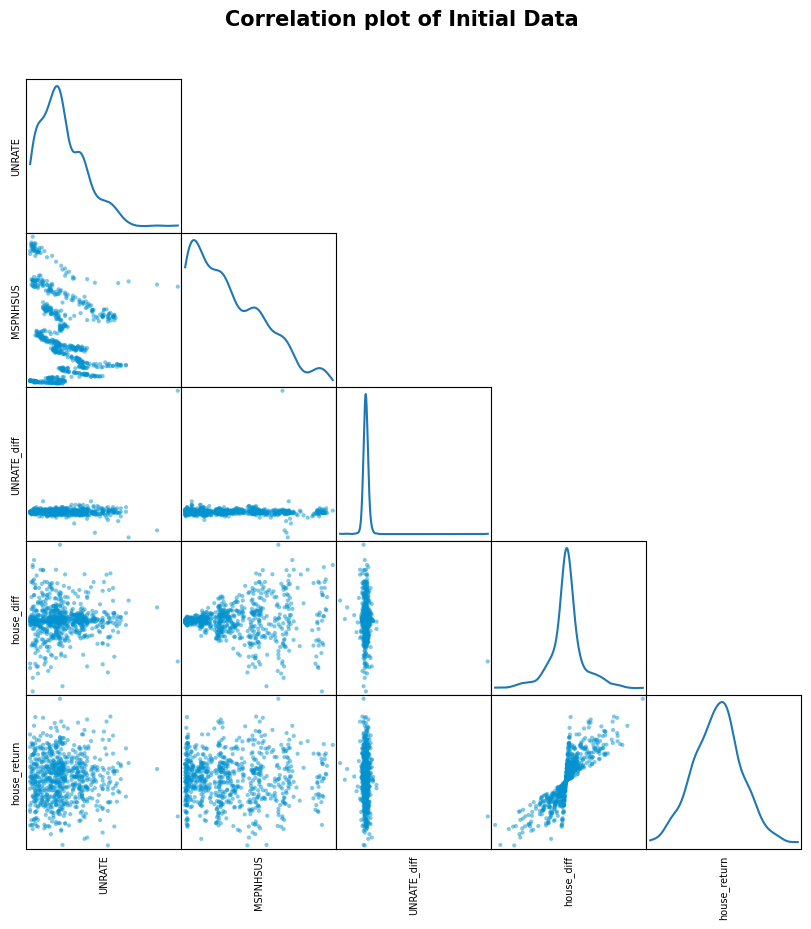

In [30]:
from matplotlib.ticker import FormatStrFormatter
from pandas.plotting import scatter_matrix
from sklearn import datasets

#diagonal is graphed by kernel density estimation (KDE)
ax = scatter_matrix(master[['UNRATE', 'MSPNHSUS','UNRATE_diff', 'house_diff', 'house_return']], 
                    color="#0392cf", alpha=0.5, figsize=(10, 10), diagonal='kde', marker = '.')

for i in range(np.shape(ax)[0]):
    for j in range(np.shape(ax)[1]):
        if i < j:
            ax[i,j].set_visible(False)

for ax in ax.ravel():
    ax.set_xlabel(ax.get_xlabel().replace(' ', '\n'), fontsize = 7, rotation = 90, weight = 'medium')
    ax.set_ylabel(ax.get_ylabel().replace(' ', '\n'), fontsize = 7, rotation = 90, weight = 'medium')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])
    
plt.suptitle('Correlation plot of Initial Data',size = 15, weight = 'bold',va = 'bottom', x= 0.5, y= 0.93)

handles = [plt.plot([],[],color=plt.cm.brg(i/2.), ls="", marker="o", \
                    markersize=np.sqrt(10))[0] for i in range(3)]
handles = [handles[0],handles[2],handles[1]]
#plt.legend(handles, loc=(1.02,0))
plt.show()

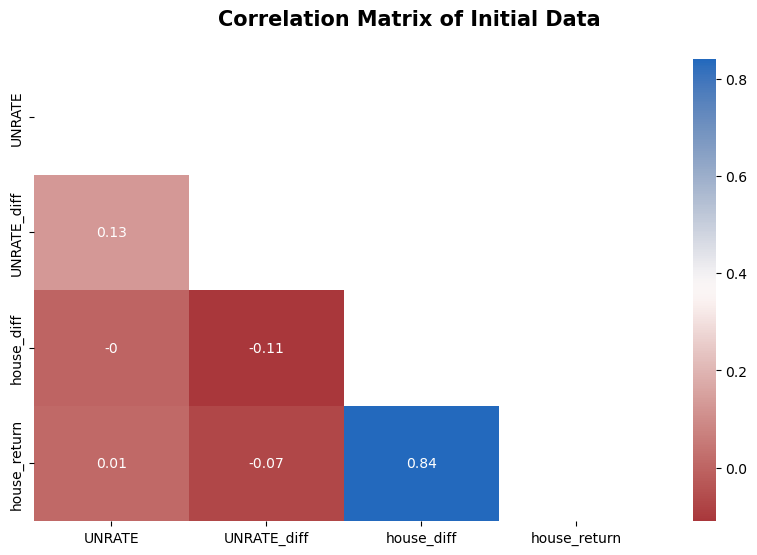

In [49]:
import seaborn as sns

corr_matrix = master[['UNRATE', 'UNRATE_diff','house_diff', 'house_return']] 
np.bool = np.bool_
corr =round(corr_matrix.corr(),2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot_kws = {'size':10}, cmap = 'vlag_r', xticklabels = corr.columns.values, 
            yticklabels = corr.columns.values, annot = True, mask = mask)
heat_map = plt.gcf()
heat_map.set_size_inches(10,6)
plt.suptitle('Correlation Matrix of Initial Data',size = 15, weight = 'bold',va = 'bottom', x= 0.5, y= 0.93)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

### 3. Benchmark Regression

In [80]:
x = master[['house_diff', 'house_return']]
reg_model = sm.OLS(master['UNRATE'],x)
result = reg_model.fit()
print(result.summary())
# R square is only 0.023

                                 OLS Regression Results                                
Dep. Variable:                 UNRATE   R-squared (uncentered):                   0.023
Model:                            OLS   Adj. R-squared (uncentered):              0.020
Method:                 Least Squares   F-statistic:                              8.548
Date:                Wed, 27 Nov 2024   Prob (F-statistic):                    0.000214
Time:                        23:33:01   Log-Likelihood:                         -2384.7
No. Observations:                 740   AIC:                                      4773.
Df Residuals:                     738   BIC:                                      4783.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

#### No Strong correlation can be seen from the above initial analysis. We see some negative correlation but not a lot. If our hypothesis is correct, we should see a higher correlation/causation when we consider more lags

## Correlation and Lag

### 1. Granger Causality up to 24 lags (look back max 24 months)

In [65]:
from statsmodels.tsa.stattools import grangercausalitytests
"""
The Null hypothesis for grangercausalitytests is that the time series in the second column, x2,
does NOT Granger cause the time series in the first column, x1. 

Grange causality means that past values of x2 have a statistically significant effect
on the current value of x1.

H1 Hypothesis: X2 (second column) is the granger cause to X1, Because the p value<0.05 
"""
#'house_diff' granger calse the 'UNRATE' by 11 lags
# Make granger test result into a better dataframe
granger_test_result = sm.tsa.stattools.grangercausalitytests(master[['UNRATE','house_diff']], maxlag=24, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7305  , p=0.3930  , df_denom=736, df_num=1
ssr based chi2 test:   chi2=0.7335  , p=0.3918  , df=1
likelihood ratio test: chi2=0.7331  , p=0.3919  , df=1
parameter F test:         F=0.7305  , p=0.3930  , df_denom=736, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4320  , p=0.6494  , df_denom=733, df_num=2
ssr based chi2 test:   chi2=0.8699  , p=0.6473  , df=2
likelihood ratio test: chi2=0.8694  , p=0.6475  , df=2
parameter F test:         F=0.4320  , p=0.6494  , df_denom=733, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5859  , p=0.6244  , df_denom=730, df_num=3
ssr based chi2 test:   chi2=1.7746  , p=0.6205  , df=3
likelihood ratio test: chi2=1.7725  , p=0.6209  , df=3
parameter F test:         F=0.5859  , p=0.6244  , df_denom=730, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5251  , p=0.7173  

C:\Users\siaha\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


### 2. Do a Correlation test with up to 24 lags to confirm granger test

In [145]:
#Make 2 dataframe to store the result: 
# one for R square and change in R square and % of valid lags with Pvalue < 5%
# Graph R-square for each lag
# one for P-value of each lag 
# The regression also shows that the best result comes from ~ 11-12 lags

# Create a new row as a dictionary
#new_row = [col, dftest[1], result]
# Append the new row
#resultdf.loc[len(resultdf)] = new_row

    
PValue_df = pd.DataFrame()
R2_df = pd.DataFrame(columns=['Column','P-Value', 'Result'])
    
    
    
nlag = 24

for i in range(1,nlag+1):
    #print(i)
    master_loop = master.copy()
    #running = i.copy()
    column_names = ['house_diff']
    pointer = 'lag' + '_' + str(i)
    print("Number of lag : ", str(i))
    while i > 0:
        text = 'lag' + '_' + str(i)
        master_loop[text] = master_loop['house_diff'].shift(i)
        column_names.append(text)
        i = i - 1
        #print(i+1)
    #print(" ")
    master_loop = master_loop.dropna()
    
    x = master_loop[column_names] 
    reg_model = sm.OLS(master_loop['UNRATE'],x)
    result = reg_model.fit()
    print("R-squared : ", result.rsquared)
    print("P-value : ")
    print(result.pvalues)
    print(" ")
    temp_df = pd.DataFrame(result.pvalues).rename(columns={0:pointer})
    PValue_df =  pd.concat([PValue_df, temp_df], axis=1)

Number of lag :  1
R-squared :  0.0178486248643569
P-value : 
house_diff    0.002256
lag_1         0.002772
dtype: float64
 
Number of lag :  2
R-squared :  0.035383754811951995
P-value : 
house_diff    0.000369
lag_2         0.000477
lag_1         0.000015
dtype: float64
 
Number of lag :  3
R-squared :  0.05744278188892493
P-value : 
house_diff    4.759220e-05
lag_3         7.621299e-05
lag_2         5.090391e-07
lag_1         4.425622e-07
dtype: float64
 
Number of lag :  4
R-squared :  0.07901275457258328
P-value : 
house_diff    3.810662e-05
lag_4         7.669172e-05
lag_3         6.082395e-08
lag_2         1.099094e-08
lag_1         3.749079e-08
dtype: float64
 
Number of lag :  5
R-squared :  0.10187636642897235
P-value : 
house_diff    2.021113e-05
lag_5         3.825789e-05
lag_4         3.819770e-08
lag_3         8.218457e-10
lag_2         5.714021e-10
lag_1         1.905234e-08
dtype: float64
 
Number of lag :  6
R-squared :  0.12244290950717507
P-value : 
house_diff    8.1

Number of lag :  23
R-squared :  0.22876019998010677
P-value : 
house_diff    0.007852
lag_23        0.018187
lag_22        0.002040
lag_21        0.001023
lag_20        0.001087
lag_19        0.001247
lag_18        0.003978
lag_17        0.019209
lag_16        0.049492
lag_15        0.096704
lag_14        0.060528
lag_13        0.048974
lag_12        0.069452
lag_11        0.074158
lag_10        0.021925
lag_9         0.007805
lag_8         0.002954
lag_7         0.000546
lag_6         0.000044
lag_5         0.000007
lag_4         0.000004
lag_3         0.000007
lag_2         0.000045
lag_1         0.000422
dtype: float64
 
Number of lag :  24
R-squared :  0.2348079734227485
P-value : 
house_diff    0.005981
lag_24        0.023107
lag_23        0.001362
lag_22        0.000444
lag_21        0.000442
lag_20        0.000861
lag_19        0.000999
lag_18        0.009153
lag_17        0.043391
lag_16        0.114193
lag_15        0.168085
lag_14        0.108855
lag_13        0.137203
lag_1

In [146]:
PValue_df

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
house_diff,0.002256,0.000369,4.759220e-05,3.810662e-05,2.021113e-05,8.117885e-05,2.251178e-04,8.152251e-04,1.555918e-03,1.632835e-03,...,1.728675e-02,0.021081,0.019049,0.019248,0.010428,0.006986,0.008836,0.007951,0.007852,0.005981
lag_1,0.002772,0.000015,4.425622e-07,3.749079e-08,1.905234e-08,2.636466e-08,2.294889e-07,1.760676e-06,1.055468e-05,2.204801e-05,...,1.155097e-03,0.001741,0.001973,0.001816,0.001215,0.000489,0.000356,0.000443,0.000422,0.000343
lag_2,NaN,0.000477,5.090391e-07,1.099094e-08,5.714021e-10,3.903727e-10,7.583743e-10,1.080227e-08,1.104999e-07,7.298893e-07,...,1.302290e-04,0.000219,0.000328,0.000373,0.000265,0.000152,0.000055,0.000036,0.000045,0.000039
lag_3,NaN,NaN,7.621299e-05,6.082395e-08,8.218457e-10,5.651826e-11,4.855156e-11,1.235076e-10,1.886119e-09,2.032472e-08,...,1.660925e-05,0.000038,0.000063,0.000098,0.000099,0.000061,0.000034,0.000010,0.000007,0.000008
lag_4,NaN,NaN,NaN,7.669172e-05,3.819770e-08,6.433422e-10,6.221315e-11,5.458499e-11,1.306188e-10,1.819021e-09,...,5.126841e-06,0.000008,0.000019,0.000032,0.000054,0.000054,0.000031,0.000016,0.000004,0.000002
lag_5,NaN,NaN,NaN,NaN,3.825789e-05,2.746085e-08,7.779119e-10,8.573951e-11,7.642096e-11,1.698104e-10,...,4.902803e-07,0.000003,0.000005,0.000010,0.000019,0.000035,0.000034,0.000018,0.000007,0.000002
lag_6,NaN,NaN,NaN,NaN,NaN,7.816606e-05,2.048961e-07,8.081453e-09,1.168130e-09,1.005290e-09,...,4.483065e-07,0.000001,0.000007,0.000010,0.000029,0.000064,0.000111,0.000103,0.000044,0.000020
lag_7,NaN,NaN,NaN,NaN,NaN,NaN,4.233124e-04,2.593212e-06,1.632297e-07,3.020589e-08,...,1.306885e-06,0.000003,0.000007,0.000032,0.000058,0.000165,0.000342,0.000584,0.000546,0.000269
lag_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.113023e-03,1.433388e-05,1.219798e-06,...,2.504073e-06,0.000006,0.000013,0.000030,0.000186,0.000353,0.000885,0.001781,0.002954,0.002918
lag_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.746707e-03,5.350478e-05,...,6.473033e-06,0.000013,0.000030,0.000059,0.000172,0.000960,0.001685,0.004032,0.007805,0.012285


### 3. Run a sample regression against the benchmark regression 

In [72]:
x = master_loop[['house_diff','house_return', 'lag_11', 'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6',
       'lag_5', 'lag_4', 'lag_3', 'lag_2', 'lag_1']]
y = master_loop['UNRATE']

In [78]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y, random_state = 4, test_size = 0.2)

In [86]:
x_bench_train = xtrain[['house_diff','house_return']]
x_bench_test = xtest[['house_diff','house_return']]
x_lag_train = xtrain[['lag_11', 'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6',
       'lag_5', 'lag_4', 'lag_3', 'lag_2', 'lag_1']]
x_lag_test = xtest[['lag_11', 'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6',
       'lag_5', 'lag_4', 'lag_3', 'lag_2', 'lag_1']]

In [84]:
# Benchmark model 
model = sm.OLS(ytrain, x_bench_train)
results = model.fit()
# Test the Model
y_pred = results.predict(x_bench_test)
# Evaluate Performance (R² on Test Data)
ss_total = np.sum((ytest - ytest.mean())**2)  # Total Sum of Squares
ss_residual = np.sum((ytest - y_pred)**2)  # Residual Sum of Squares
r_squared_test = 1 - (ss_residual / ss_total)
print("The R-squre of trained model is: ", results.rsquared)
print("The MSE of trained model is: ", results.mse_resid)
print("The R-squre of tested model is: ", r_squared_test)
print("The MSE of tested model is: ", results.mse_resid)

The R-squre of trained model is:  0.03194346594082065
The MSE of trained model is:  37.65285702558466
The R-squre of tested model is:  -13.114083153239266


In [87]:
# lag model 
model = sm.OLS(ytrain, x_lag_train)
results = model.fit()
# Test the Model
y_pred = results.predict(x_lag_test)
# Evaluate Performance (R² on Test Data)
ss_total = np.sum((ytest - ytest.mean())**2)  # Total Sum of Squares
ss_residual = np.sum((ytest - y_pred)**2)  # Residual Sum of Squares
r_squared_test = 1 - (ss_residual / ss_total)
print("The R-squre of trained model is: ", results.rsquared)
print("The MSE of trained model is: ", results.mse_resid)
print("The R-squre of tested model is: ", r_squared_test)
print("The MSE of tested model is: ", results.mse_resid)

The R-squre of trained model is:  0.1757335587130795
The MSE of trained model is:  32.59147990862404
The R-squre of tested model is:  -11.214817385681306


### 4. Rerun the correlation graph again with diff # lag 
#### using a moving average with # lags, so in that way we can include infomation from all lagas and graph with 2 variables
#### we can try to include more past information, since the more we look back the better the result

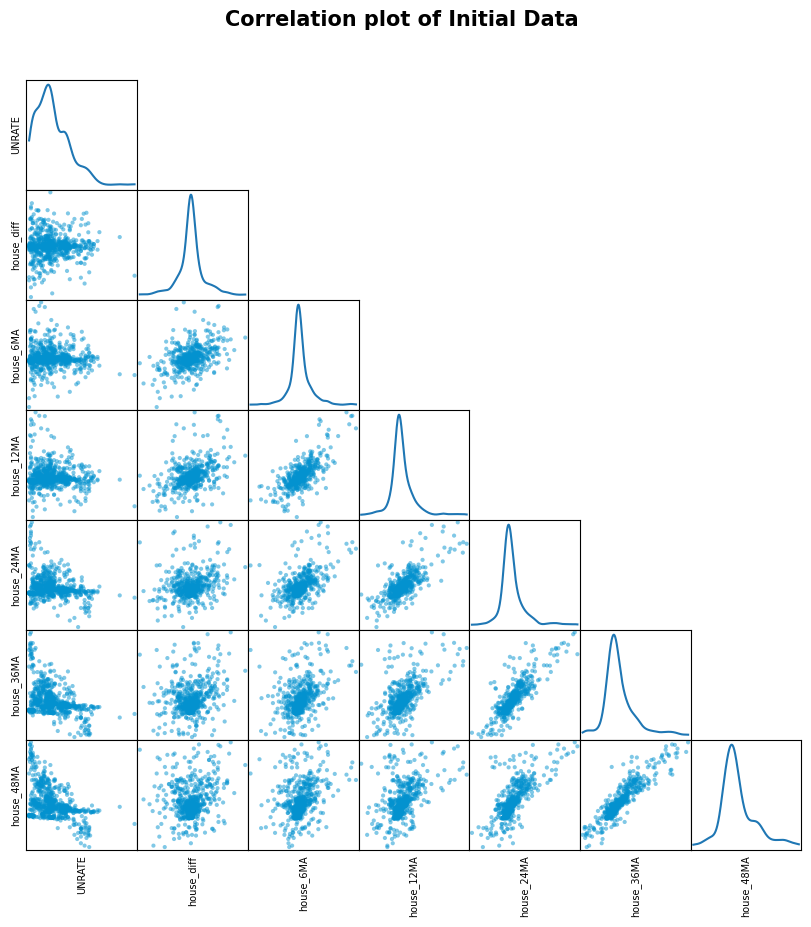

In [102]:
from matplotlib.ticker import FormatStrFormatter
from pandas.plotting import scatter_matrix
from sklearn import datasets

master['house_6MA'] = master['house_diff'].rolling(window=6).mean()
master['house_12MA'] = master['house_diff'].rolling(window=12).mean()
master['house_24MA'] = master['house_diff'].rolling(window=24).mean()
master['house_36MA'] = master['house_diff'].rolling(window=36).mean()
master['house_48MA'] = master['house_diff'].rolling(window=48).mean()
master['house_60MA'] = master['house_diff'].rolling(window=60).mean()
#diagonal is graphed by kernel density estimation (KDE)
ax = scatter_matrix(master[['UNRATE', 'house_diff','house_6MA','house_12MA','house_24MA','house_36MA','house_48MA']], 
                    color="#0392cf", alpha=0.5, figsize=(10, 10), diagonal='kde', marker = '.')

for i in range(np.shape(ax)[0]):
    for j in range(np.shape(ax)[1]):
        if i < j:
            ax[i,j].set_visible(False)

for ax in ax.ravel():
    ax.set_xlabel(ax.get_xlabel().replace(' ', '\n'), fontsize = 7, rotation = 90, weight = 'medium')
    ax.set_ylabel(ax.get_ylabel().replace(' ', '\n'), fontsize = 7, rotation = 90, weight = 'medium')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])
    
plt.suptitle('Correlation plot of Initial Data',size = 15, weight = 'bold',va = 'bottom', x= 0.5, y= 0.93)

handles = [plt.plot([],[],color=plt.cm.brg(i/2.), ls="", marker="o", \
                    markersize=np.sqrt(10))[0] for i in range(3)]
handles = [handles[0],handles[2],handles[1]]
#plt.legend(handles, loc=(1.02,0))
plt.show()

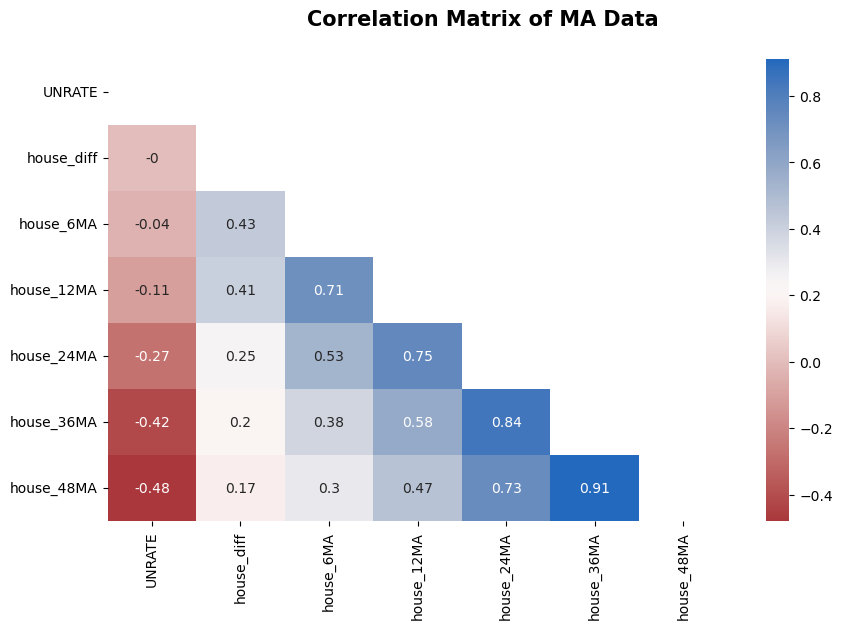

In [103]:
import seaborn as sns

corr_matrix = master[['UNRATE','house_diff','house_6MA','house_12MA','house_24MA','house_36MA','house_48MA']] 
np.bool = np.bool_
corr =round(corr_matrix.corr(),2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot_kws = {'size':10}, cmap = 'vlag_r', xticklabels = corr.columns.values, 
            yticklabels = corr.columns.values, annot = True, mask = mask)
heat_map = plt.gcf()
heat_map.set_size_inches(10,6)
plt.suptitle('Correlation Matrix of MA Data',size = 15, weight = 'bold',va = 'bottom', x= 0.5, y= 0.93)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

# Though we know that the more look back we have the better the result, from a statistic perspect, 
# we are confident enough to say that there is a negative correlation + housing market price 
# is granger cause to the unemployment rate with 11 lags

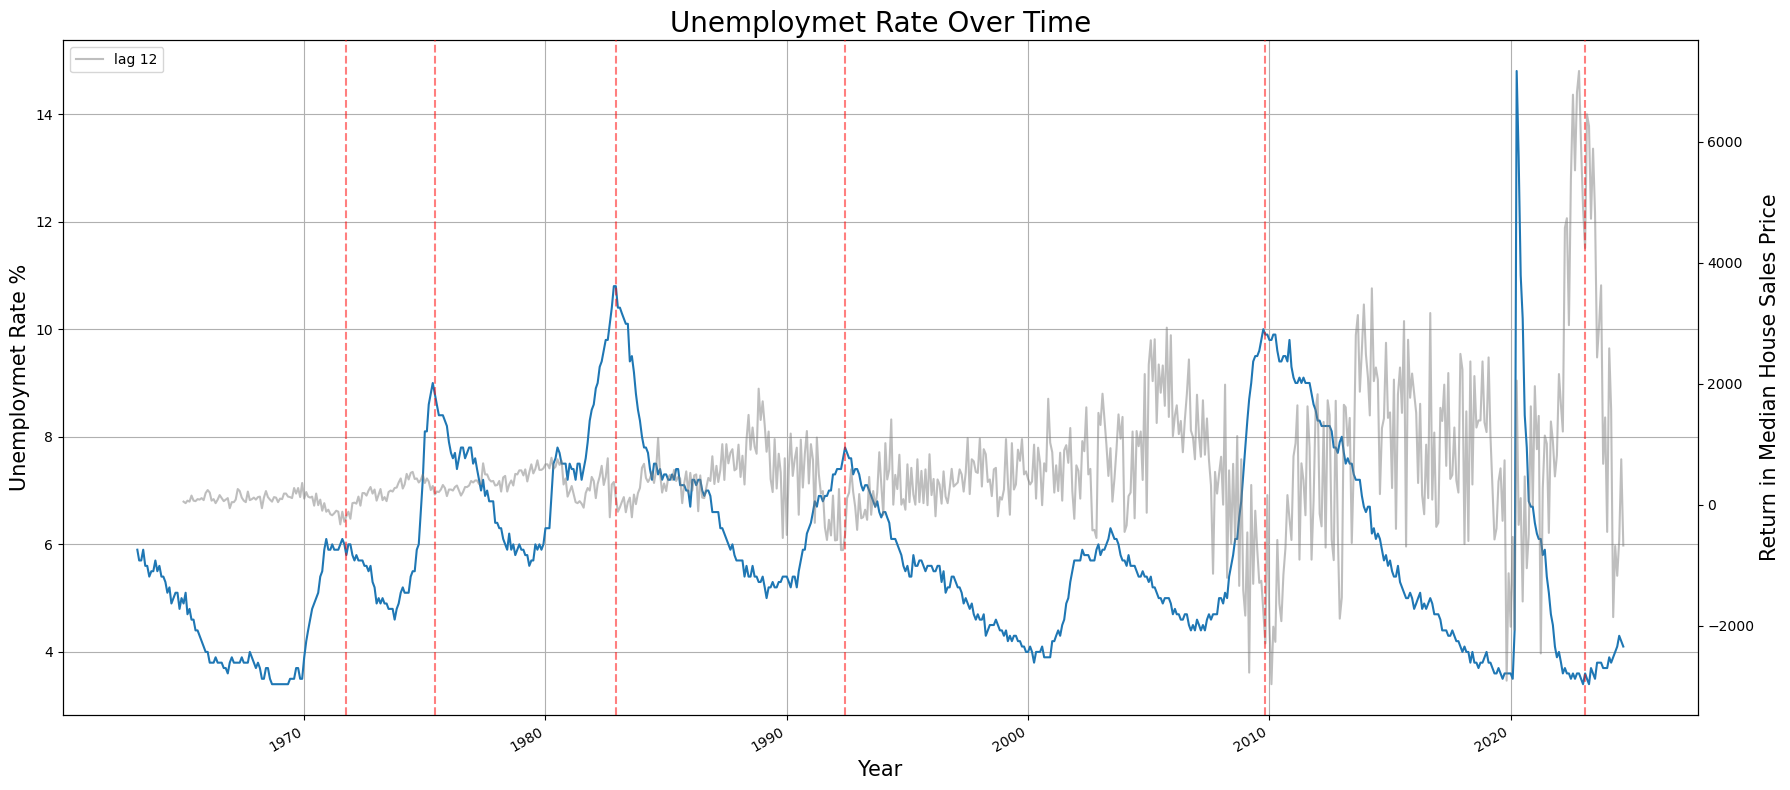

In [123]:
master['house_lag12'] = master['house_12MA'].shift(12)
fig, ax1 = plt.subplots(figsize = (18,8))
ax1.plot(master.index, 'UNRATE', data=master, color = 'tab:blue',label = 'UNRATE')

ax1.set_xlabel('Year',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_ylabel('Unemploymet Rate %',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_title('Unemploymet Rate Over Time', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax1.grid(True)

ax2 = ax1.twinx()  
ax2.plot(master.index, 'house_lag12', data=master, color = 'tab:grey', alpha=0.5,label = 'lag 12')
ax2.tick_params(axis = 'y') #,labelcolor = color)
ax2.set_ylabel('Return in Median House Sales Price', size = 15)
plt.legend(loc='upper left')

#Year break is unemployment peak or trough
ax3 = ax1.twinx()
break_year = np.datetime64(date(1971, 10, 1).strftime('%Y-%m-%d'))
ax3.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax3.axis('off')

ax4 = ax1.twinx()
break_year = np.datetime64(date(1975, 6, 1).strftime('%Y-%m-%d'))
ax4.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax4.axis('off')

ax5 = ax1.twinx()
break_year = np.datetime64(date(1982, 12, 1).strftime('%Y-%m-%d'))
ax5.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax5.axis('off')

ax6 = ax1.twinx()
break_year = np.datetime64(date(1992, 6, 1).strftime('%Y-%m-%d'))
ax6.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax6.axis('off')

ax7 = ax1.twinx()
break_year = np.datetime64(date(2009, 11, 1).strftime('%Y-%m-%d'))
ax7.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax7.axis('off')

ax8 = ax1.twinx()
break_year = np.datetime64(date(2023, 2, 1).strftime('%Y-%m-%d'))
ax8.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax8.axis('off')

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()